# Imports

In [15]:
import logging
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [16]:
log_file_path = 'mnist logs.log'
model_save_path = 'mnist_model.h5'


logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.DEBUG)

formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

logger.addHandler(file_handler)

for handler in logger.handlers[:]:
    if isinstance(handler, logging.StreamHandler): # Removing StreamHandler, it outputs logs to the kernel, which is higly annoying and clumsy
        logger.removeHandler(handler)

logger.info("Logging configuration is set. Logs will be saved to: {}".format(log_file_path))

# Preprocessing

In [17]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
logging.info("MNIST dataset loaded.")
print("Before flattening: ", train_images.shape)

train_images = train_images.reshape(train_images.shape[0], -1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], -1).astype('float32') / 255.0
print("After flattening: ", train_images.shape)
logging.info("Data reshaped and normalized.")

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)
logging.info("Labels one-hot encoded.")

train_data, val_data, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, shuffle=True
)
logging.info("Training data split into training and validation sets.")

Before flattening:  (60000, 28, 28)
After flattening:  (60000, 784)


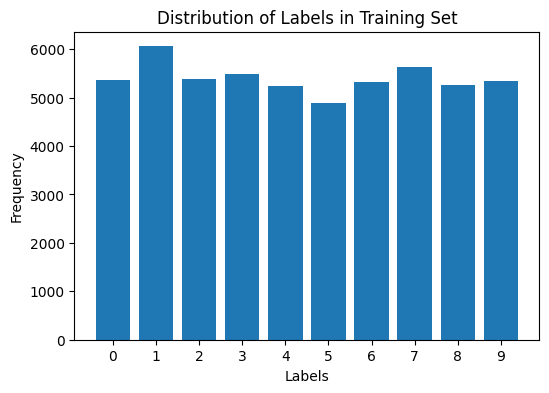

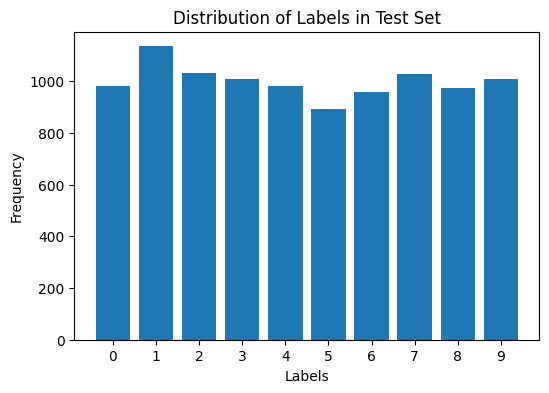

In [19]:
def plot_label_distribution(labels, dataset_name):
    label_distribution = np.sum(labels, axis=0)
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(label_distribution)), label_distribution, tick_label=range(len(label_distribution)))
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Labels in {dataset_name} Set')
    plt.show()

plot_label_distribution(train_labels, 'Training')
plot_label_distribution(test_labels, 'Test')

# Model Compilation, Training & Evaluation

In [20]:
"""model = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
logging.info("Neural network model built.")"""

model = Sequential([
    Dense(128, input_shape=(784,)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(10, activation='softmax')
])

logging.info("Neural network built.")

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
logging.info("Model compiled.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
epochs = 5
batch_size = 32

history = model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=5,
    batch_size=32
)

test_loss, test_accuracy = model.evaluate(test_images, test_labels)
logging.info(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

model.save(model_save_path)
logging.info(f"Model saved as {model_save_path}.")

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8195 - loss: 0.6133 - val_accuracy: 0.9522 - val_loss: 0.1556
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9347 - loss: 0.2158 - val_accuracy: 0.9617 - val_loss: 0.1237
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9475 - loss: 0.1764 - val_accuracy: 0.9668 - val_loss: 0.1032
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9546 - loss: 0.1476 - val_accuracy: 0.9713 - val_loss: 0.0933
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9580 - loss: 0.1338 - val_accuracy: 0.9735 - val_loss: 0.0848
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9728 - loss: 0.0914
Test Accuracy: 97.73%


# Results

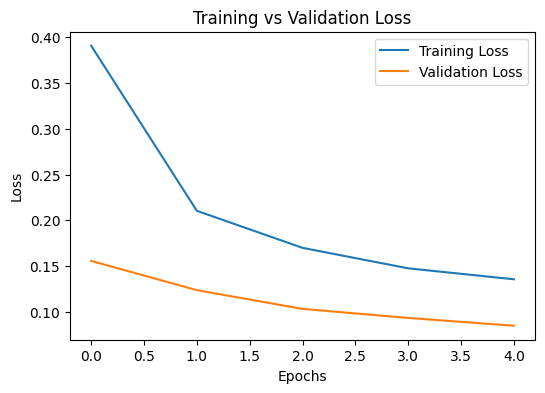

In [22]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

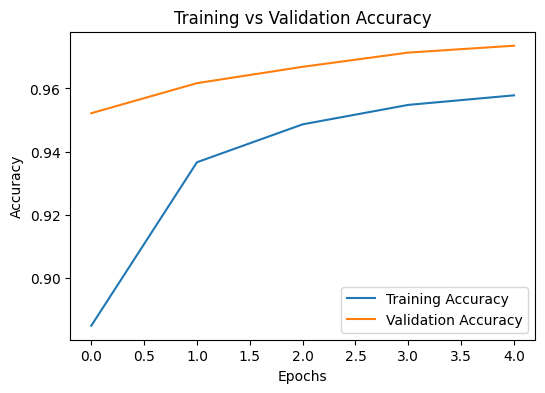

In [23]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


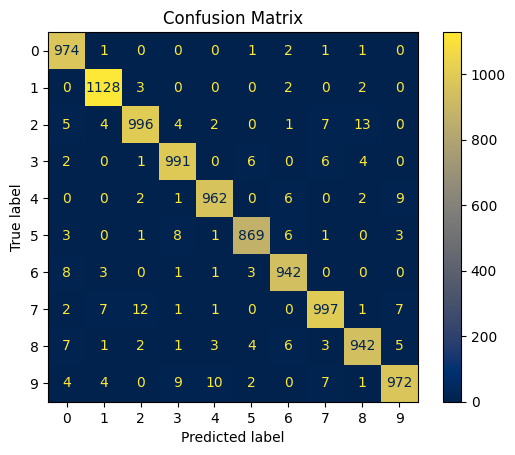

In [24]:
predicted_labels = model.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)
true_classes = np.argmax(test_labels, axis=1)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=range(10)).plot(cmap='cividis') #, xticks_rotation='vertical'
plt.title('Confusion Matrix')
plt.show()
logging.info("Confusion matrix displayed.")

In [25]:
logging.info("Summary of Results:")
logging.info(f"Final Training Accuracy: {history.history['accuracy']}%")
logging.info(f"Final Validation Accuracy: {history.history['val_accuracy']}%")
logging.info(f"Test Accuracy: {test_accuracy * 100:.2f}%")

print("\nSummary of Results:")
print(f"Final Training Accuracy: {history.history['accuracy']}%")
print(f"Final Validation Accuracy: {history.history['val_accuracy']}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Summary of Results:
Final Training Accuracy: [0.8849814534187317, 0.9366666674613953, 0.9486481547355652, 0.954796314239502, 0.9578148126602173]%
Final Validation Accuracy: [0.9521666765213013, 0.9616666436195374, 0.9668333530426025, 0.9713333249092102, 0.9735000133514404]%
Test Accuracy: 97.73%
